In [10]:
from pycalphad import Database, Model, calculate, equilibrium, variables as v
from xarray import DataArray

In [11]:
class PrecipitateModel(Model):
    matrix_chempots = []
    @property
    def matrix_hyperplane(self):
        return sum(self.moles(self.nonvacant_elements[i])*self.matrix_chempots[i]
                   for i in range(len(self.nonvacant_elements)))
    @property
    def GM(self):
        return self.ast - self.matrix_hyperplane

In [31]:
def parallel_tangent(dbf, comps, matrix_phase, matrix_comp, precipitate_phase):
    temp = 600 # K
    conds = {v.N: 1, v.P: 1e5, v.T: temp}
    conds.update(matrix_comp)
    matrix_eq = equilibrium(dbf, comps, matrix_phase, conds)
    matrix_chempots = matrix_eq.MU.values.flatten()
    print(matrix_chempots)
    # Will not work until mass balance constraint can be relaxed
    #precip = PrecipitateModel(dbf, comps, precipitate_phase)
    #precip.matrix_chempots = matrix_chempots
    #conds = {v.N: 1, v.P: 1e5, v.T: temp}
    #df_eq = equilibrium(dbf, comps, precipitate_phase, conds, model=precip)
    df_eq = calculate(dbf, comps, precipitate_phase, T=temp, N=1, P=1e5)
    print(df_eq)
    df_eq['GM'] = df_eq.GM - df_eq.X.values[0,0,0].dot(matrix_chempots)
    selected_idx = df_eq.GM.argmax()
    return df_eq.isel(points=selected_idx)
    
dbf = Database('Al-Cu-Zr_Zhou.tdb')
comps = ['CU', 'ZR', 'VA']
parallel_tangent(dbf, comps, 'LIQUID', {v.X('CU'): 0.4}, 'BCC_A2')

[-48964.09186754 -24922.57302051]
<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 1, component: 2, internal_dof: 3, points: 4002)
Coordinates:
  * component  (component) <U2 'CU' 'ZR'
  * N          (N) float64 1.0
  * P          (P) float64 1e+05
  * T          (T) float64 600.0
Dimensions without coordinates: internal_dof, points
Data variables:
    X          (N, P, T, points, component) float64 1.0 1e-15 ... 0.7439 0.2561
    Phase      (N, P, T, points) <U6 'BCC_A2' 'BCC_A2' ... 'BCC_A2' 'BCC_A2'
    Y          (N, P, T, points, internal_dof) float64 1.0 1e-15 ... 0.2561 1.0
    GM         (N, P, T, points) float64 -1.96e+04 -2.394e+04 ... -2.412e+04


<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 1, component: 2, internal_dof: 3)
Coordinates:
  * component  (component) <U2 'CU' 'ZR'
  * N          (N) float64 1.0
  * P          (P) float64 1e+05
  * T          (T) float64 600.0
Dimensions without coordinates: internal_dof
Data variables:
    X          (N, P, T, component) float64 1.0 1e-15
    Phase      (N, P, T) <U6 'BCC_A2'
    Y          (N, P, T, internal_dof) float64 1.0 1e-15 1.0
    GM         (N, P, T) float64 2.936e+04

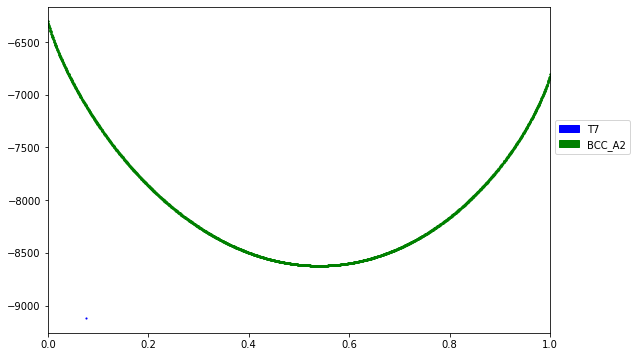

In [39]:
from pycalphad import calculate
import matplotlib.pyplot as plt
from pycalphad.plot.utils import phase_legend
import numpy as np

my_phases = ['T7', 'BCC_A2']
legend_handles, colorlist = phase_legend(my_phases)

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
for name in my_phases:
    result = calculate(dbf, ['CU', 'ZR', 'VA'], name, P=101325, T=300, output='GM')
    ax.scatter(result.X.sel(component='ZR'), result.GM,
               marker='.', s=5, color=colorlist[name.upper()])
ax.set_xlim((0, 1))
ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.6))
plt.show()

In [37]:
dbf.phases

{'LIQUID': Phase({'name': 'LIQUID', 'constituents': (frozenset({Species('ZR', 'ZR1'), Species('AL', 'AL1'), Species('CU', 'CU1')}),), 'sublattices': (1.0,), 'model_hints': {'liquid': True}}),
 'AL2CU': Phase({'name': 'AL2CU', 'constituents': (frozenset({Species('AL', 'AL1')}), frozenset({Species('AL', 'AL1'), Species('CU', 'CU1')})), 'sublattices': (2.0, 1.0), 'model_hints': {}}),
 'AL2ZR': Phase({'name': 'AL2ZR', 'constituents': (frozenset({Species('AL', 'AL1'), Species('CU', 'CU1')}), frozenset({Species('ZR', 'ZR1')})), 'sublattices': (2.0, 1.0), 'model_hints': {}}),
 'AL2ZR3': Phase({'name': 'AL2ZR3', 'constituents': (frozenset({Species('AL', 'AL1'), Species('CU', 'CU1')}), frozenset({Species('ZR', 'ZR1')})), 'sublattices': (2.0, 3.0), 'model_hints': {}}),
 'AL3ZR2': Phase({'name': 'AL3ZR2', 'constituents': (frozenset({Species('AL', 'AL1'), Species('CU', 'CU1')}), frozenset({Species('ZR', 'ZR1')})), 'sublattices': (3.0, 2.0), 'model_hints': {}}),
 'AL3ZR4': Phase({'name': 'AL3ZR4', 